In [1]:
import torch
from torch import Tensor
import numpy as np
from typing import Tuple
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import wget
import torchvision
from torchvision import transforms
import numbers
import random
import math
import torch.nn as nn
from PIL import Image, ImageFilter
from skimage import color
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from torchvision.transforms import functional as F
from scipy.fft import fft, rfft, irfft, ifft,fftshift, fft2, ifft2, dct, idct
from pytorch_wavelets import DWTForward, DWTInverse # (or import DWT, IDWT)
import seaborn as sns

In [140]:
scale_factor=6
steps = 30

In [141]:
xfm = DWTForward(J=scale_factor, mode='reflect', wave='db3')  # Accepts all wave types available to PyWavelets
ifm = DWTInverse(mode='reflect', wave='db3')

In [142]:
def img_norm_min_max(img_: Tensor) -> Tensor:
    img_norm_ = img_ - img_.min()
    img_norm_ = img_norm_ / (img_norm_.max() + EPS)
    return img_norm_
def img_norm(img_: Tensor) -> Tensor:
    img_norm_ = img_ - img_.mean((-2, -1), keepdim=True)
    img_norm_ = img_norm_ / (img_norm_.std((-2, -1), keepdim=True) + EPS)
    return img_norm_

In [143]:
img_lena = Image.open("lena.jpg")
img_lena_gray_tensor = transforms.ToTensor()(transforms.Grayscale()(img_lena))

In [144]:
lena_gray_Yl, lena_gray_Yh = xfm(img_lena_gray_tensor[None])

In [145]:
lena_gray_Yl.shape, lena_gray_Yh[0].abs().max(), lena_gray_Yh[-1].abs().max()

(torch.Size([1, 1, 12, 12]), tensor(0.5452), tensor(15.8801))

In [146]:
def shrink_hard(x, t: float):
    """ Given a wavelet coefficient and a threshold, shrink """
    if t == 0:
        return x
    m = x.abs()
    gain = (m > t).to(dtype=x.dtype)
    return x * gain

In [147]:
def apply_term(coeff_yh, thresh):
    coeff_yh_shink = []
    for y_p in coeff_yh:
        coeff_yh_shink.append(shrink_hard(y_p, thresh))
    return  coeff_yh_shink

In [148]:
def build_tresh(y_h, steps):
    max_coeff = 0 
    for y_p in y_h:
        max_coeff = max(max_coeff, y_p.abs().max())
    tresh_step = max_coeff/(steps)
    
    tresh_scheduler = [tresh_step*(ind+1) for ind in range(steps)]
    tresh_scheduler = [0.0] + tresh_scheduler
    return tresh_scheduler

In [149]:
tresh_scheduler = build_tresh(lena_gray_Yh, steps)

In [150]:
tresh_scheduler

[0.0,
 tensor(0.5293),
 tensor(1.0587),
 tensor(1.5880),
 tensor(2.1173),
 tensor(2.6467),
 tensor(3.1760),
 tensor(3.7054),
 tensor(4.2347),
 tensor(4.7640),
 tensor(5.2934),
 tensor(5.8227),
 tensor(6.3520),
 tensor(6.8814),
 tensor(7.4107),
 tensor(7.9401),
 tensor(8.4694),
 tensor(8.9987),
 tensor(9.5281),
 tensor(10.0574),
 tensor(10.5867),
 tensor(11.1161),
 tensor(11.6454),
 tensor(12.1748),
 tensor(12.7041),
 tensor(13.2334),
 tensor(13.7628),
 tensor(14.2921),
 tensor(14.8214),
 tensor(15.3508),
 tensor(15.8801)]

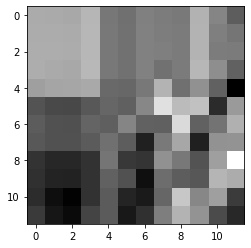

In [151]:
plt.imshow(lena_gray_Yl[0,0], cmap='gray', interpolation='none')

In [152]:
def build_y_h_non_linear_diff(y_h, tresh_scheduler):
    y_h_aprox_diff = []
    for tresh_ in tresh_scheduler:
        y_h_shirnk =  apply_term(y_h, thresh=tresh_)
        y_h_aprox_diff.append(y_h_shirnk)
    return y_h_aprox_diff

In [153]:
y_h_lena_gray_aprox_diff = build_y_h_non_linear_diff(lena_gray_Yh, tresh_scheduler)

In [154]:
len(y_h_lena_gray_aprox_diff)

31

In [155]:
lena_gray_recon = ifm((lena_gray_Yl, lena_gray_Yh))

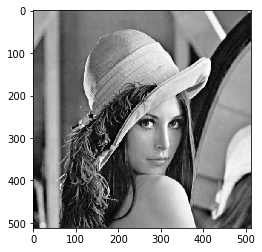

In [156]:
plt.imshow(lena_gray_recon[0,0], cmap='gray', interpolation='none')

In [157]:
def build_recon_non_linear_aprox(y_l, y_h_aprox_diff):
    recon_img_non_linear_aprox = []
    for y_h in y_h_aprox_diff:
        recon_img_non_linear_aprox.append(ifm((y_l, y_h)))
    return recon_img_non_linear_aprox

In [158]:
recon_img_non_linear_aprox_lena_gray = build_recon_non_linear_aprox(lena_gray_Yl, y_h_lena_gray_aprox_diff)

In [159]:
recon_img_non_linear_aprox_lena_gray[0].shape

torch.Size([1, 1, 512, 512])

In [165]:
for ind in range(len(recon_img_non_linear_aprox_lena_gray)):
    recon_aprox_img = recon_img_non_linear_aprox_lena_gray[ind]
    y_h = y_h_lena_gray_aprox_diff[ind]
    l1_norm = [torch.linalg.vector_norm(y_h_, 1).numpy() for y_h_ in y_h]
    l2_err = nn.MSELoss()(lena_gray_recon, recon_aprox_img).numpy()
    print(f'l2_err={l2_err}, l1_norm={l1_norm}')

l2_err=0.0, l1_norm=[array(2261.674, dtype=float32), array(2118.837, dtype=float32), array(1682.09, dtype=float32), array(1274.3066, dtype=float32), array(1151.1963, dtype=float32), array(1076.2832, dtype=float32)]
l2_err=0.0030172611586749554, l1_norm=[array(0.54517007, dtype=float32), array(137.51674, dtype=float32), array(589.43744, dtype=float32), array(850.1627, dtype=float32), array(1020.0849, dtype=float32), array(1047.4232, dtype=float32)]
l2_err=0.005665197968482971, l1_norm=[array(0., dtype=float32), array(3.599299, dtype=float32), array(177.59106, dtype=float32), array(554.1971, dtype=float32), array(867.872, dtype=float32), array(1014.05084, dtype=float32)]
l2_err=0.007854031398892403, l1_norm=[array(0., dtype=float32), array(0., dtype=float32), array(45.562477, dtype=float32), array(348.90485, dtype=float32), array(741.4756, dtype=float32), array(938.1447, dtype=float32)]
l2_err=0.009807462804019451, l1_norm=[array(0., dtype=float32), array(0., dtype=float32), array(11.699

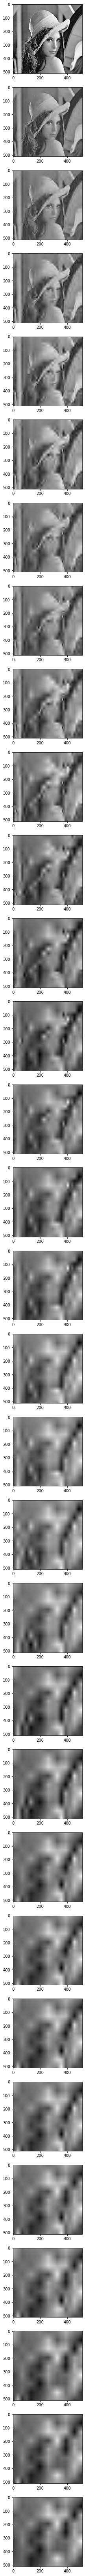

In [161]:
len_ = len(recon_img_non_linear_aprox_lena_gray)
fig, axs = plt.subplots(len_, 1, figsize=(18, 120))
for ind in range(len_):
    axs[ind].imshow(recon_img_non_linear_aprox_lena_gray[ind][0,0], cmap='gray', interpolation='none')
